# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

# (Step1) Raw data cleaning process

- `ttc-bus-delay-data-2022.csv`

- Create target variable 
  - if delay_mins = 0 -> drop
  - 0 -> delay within 5 mins - okay 
  - 1 -> delay more than 5 mins but came eventually - not good
  - 2 -> never came - bad 

In [2]:
url = "https://raw.githubusercontent.com/Sofiaanjum/TTC_Bus_Delay_Prediction/main/ttc-bus-delay-data-2022.csv"

In [3]:
df = pd.read_csv('url')
df.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,1-Jan-22,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,NaN,8531
1,1-Jan-22,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,W,8658
2,1-Jan-22,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,S,0
3,1-Jan-22,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,S,0
4,1-Jan-22,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,S,0


## functions for cleaning 
- `clean_route`
- `clean_cloumns`
- `datetime_col`
- `location_name`
- `categorize` lambda function

In [4]:
# what if delay_mins = 0
# 0 -> delay within 5 mins - okay 
# 1 -> delay more than 5 mins but came eventually - not good
# 2 -> never came - bad 

def categorize(min_gap, min_delay):
  if min_gap == 2 * min_delay: #bus never shows up = 2
    return 2
  elif min_gap < min_delay: #second bus came after 3rd bus = 2
    return 2
  elif min_gap >= min_delay and min_gap <= 5: #delay 5 mins is fine = 0
    return 0
  else:  #delay more than 5 mins but came eventually = 1
    return 1

In [5]:
def clean_route(df):

  print('Before cleaning, there are {} unique bus route in dataset. The dataset has {} rows.'.format(df.Route.nunique(),df.shape[0]))
  # combine 'RAD' ("Run as Directed") with Route 600 
  df.loc[df['Route'] == '600 RAD (LINE 1', 'Route'] = '600'
  df.loc[df['Route'] == 'RAD', 'Route'] = '600'


  #df['Route'] == '927 HIGHWAY 27' only runs in May, it replace regular Route 927 (which does not have May data)
  # change '927 HIGHWAY 27' to '27'
  df.loc[df['Route'] == '927 HIGHWAY 27', 'Route'] = '927'

  #drop MinDelay == 0
  df = df[~(df.MinDelay == 0)]


  # drop Route with < 3 incidents, and consider them as outliers
  a = df.Route.value_counts()
  b = pd.DataFrame({'Name': a.index, 'Count': a.values})
  few_incident_route = list(b[b.Count < 3].Name)
  df = df[~df.Route.isin(few_incident_route)]

  # drop 'RAD' and 'OTC', because those routes does not have a regular schedule and does not have impact on passangers
  df=df[~(df.Route == 'RAD')]
  df=df[~(df.Route == 'OTC')]


  #drop Route == NaN
  df = df[~(df.Route.isnull())]


  print('After cleaning, there are {} unique bus route in dataset. The dataset has {} rows.'.format(df.Route.nunique(),df.shape[0]))

  return df



def clean_cloumns(df):
  # Direction col
  print('Before: there are {} unique values in "Direction" column.'.format(df.Direction.nunique()))
  df.loc[df.Direction.isnull(), 'Direction'] = 'A'
  df.loc[df.Direction.isin(['J','Q', '/', 'D', 'I','2','6']), 'Direction'] = 'A'
  print('After: there are {} unique values in "Direction" column.'.format(df.Direction.nunique()))

  # rename columns with space 
  df = df.rename(columns={'Min Delay': 'MinDelay', 'Min Gap': 'MinGap'})
  
  return df



def datetime_col(df):

  
  # convert the 'Date' & 'Time' column to datetime format (for future seasonality test)
  df['Date'] = pd.to_datetime(df['Date'])
  df['Time'] = pd.to_datetime(df['Time'])


  #get new 'Month' col
  df['Month'] = df['Date'].dt.strftime('%B') #df['Date'].dt.month for numbers
 
  # 'Time' column: round to the nearest half hour 
  df['Time'] = (df['Time'].dt.round('30min')).dt.time # format for extracting time details: df['Time'].dt.strftime('%H:%M:%S')

  return df



In [6]:
# from geopy.geocoders import Nominatim
def location_name(df):

  #change location with AND -> & because geopy could not recoginize 
  df['Location'] = df['Location'].str.replace('AND', '&')

  # GO STATION -> GO 
  df['Location'] = df['Location'].str.replace('GO STATION', 'GO') 
  # replace mis spelling words 
  # add something

  #add 'Toronto'
  df['Location'] = df['Location'] + ', Toronto'

  return df

## run function to get clean dataframe

In [7]:
#df = pd.read_csv('/content/drive/MyDrive/ttc-bus-delay-data-2022.csv')

df = clean_cloumns(df)
df = clean_route(df)
df = datetime_col(df)
df = location_name(df) #GO STATION -> GO

df['Category'] = df.apply(lambda x: categorize(x['MinGap'], x['MinDelay']), axis=1) #add target column


Before: there are 12 unique values in "Direction" column.
After: there are 6 unique values in "Direction" column.
Before cleaning, there are 223 unique bus route in dataset. The dataset has 27351 rows.
After cleaning, there are 194 unique bus route in dataset. The dataset has 26005 rows.


In [8]:
df.sample(10)

,Date,Route,Time,Day,Location,Incident,MinDelay,MinGap,Direction,Vehicle,Month,Category
13926,2022-04-01,53,07:00:00,Friday,"AMAZON LOOP, Toronto",Mechanical,6,12,W,3262,April,2
4505,2022-01-22,94,20:30:00,Saturday,"OSSINGTON STATION, Toronto",Mechanical,9,18,E,8535,January,2
6845,2022-02-07,45,15:30:00,Monday,"KIPLING & EGLINTON, Toronto",Mechanical,16,32,W,1409,February,2
26430,2022-06-24,94,20:00:00,Friday,"COLLEGE & BAY, Toronto",Held By,10,20,E,8424,June,2
21516,2022-05-24,97,15:00:00,Tuesday,"YONGE & LAKE SHORE, Toronto",Diversion,230,260,N,8487,May,1
12985,2022-03-25,17,08:30:00,Friday,"WARDEN STATION, Toronto",Security,8,16,A,3280,March,2
3924,2022-01-19,102,19:00:00,Wednesday,"MARKHAM & FINCH, Toronto",Emergency Services,10,20,N,3407,January,2
1241,2022-01-06,939,15:00:00,Thursday,"FINCH STATION, Toronto",Operations - Operator,2,10,A,3232,January,1
17170,2022-04-25,935,20:00:00,Monday,"JANE STATION, Toronto",Utilized Off Route,12,24,S,1060,April,2
20624,2022-05-17,24,13:00:00,Tuesday,"STEELES LOOP, Toronto",Operations - Operator,10,20,N,8559,May,2


## save cleaned df to csv just in case

In [9]:
df.to_csv('/content/drive/MyDrive/cleaned_ttc_v3.csv', index = False)

# (Step 2) Load cleaned df
-`cleaned_ttc_v3.csv`

In [10]:
df = pd.read_csv('/content/drive/MyDrive/cleaned_ttc_v3.csv')
# because csv formatting
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

In [11]:
df.sample(2)

,Date,Route,Time,Day,Location,Incident,MinDelay,MinGap,Direction,Vehicle,Month,Category
7533,2022-02-16,996,2023-04-20 14:00:00,Wednesday,"JOHN GARL& & MARTI, Toronto",Mechanical,12,24,W,3541,February,2
13573,2022-04-04,47,2023-04-20 15:30:00,Monday,"EARLSCOURT LOOP, Toronto",Utilized Off Route,12,24,N,8195,April,2


# (Step-3) Constructing new dataframe for Model prediction

- route_often_delay `df.Route.value_counts() `>  52 twice per week

- time of day
- week 
- month
- weather - (maybe)
- at_busy_station `df.Location.value_counts()` > 52 [:55] 

Feature Labels: 
[1 = busy route, 0= not a busy route]


In [12]:
route_df = pd.DataFrame(df.Route.value_counts()[:121])  # top 121 route 
route_list = list(route_df.index)

In [13]:
df.Location.value_counts()[50:56]
location_df = pd.DataFrame(df.Location.value_counts()[:55])  # top 55 location 
location_list = list(location_df.index)

In [14]:
df2 = df.copy(deep = True)
df2['busy_location'] = df['Location'].isin(location_list)+0
df2['busy_route'] = df['Route'].isin(route_list)+0
df2.head()

,Date,Route,Time,Day,Location,Incident,MinDelay,MinGap,Direction,Vehicle,Month,Category,busy_location,busy_route
0,2022-01-01,325,2023-04-20 02:00:00,Saturday,"OVERLEA & THORCLIFFE, Toronto",Diversion,131,161,W,8658,January,1,0,0
1,2022-01-01,320,2023-04-20 02:00:00,Saturday,"YONGE & STEELES, Toronto",Operations - Operator,17,20,S,0,January,1,1,1
2,2022-01-01,320,2023-04-20 02:00:00,Saturday,"YONGE & STEELES, Toronto",Operations - Operator,4,11,S,0,January,1,1,1
3,2022-01-01,320,2023-04-20 02:00:00,Saturday,"YONGE & STEELES, Toronto",Operations - Operator,4,8,S,0,January,2,1,1
4,2022-01-01,363,2023-04-20 02:30:00,Saturday,"KING & SHAW, Toronto",Operations - Operator,30,60,A,0,January,2,0,0


In [15]:

#df2['Time'] = df2['Time'].dt.strftime('%H:%M')

In [16]:
df2['Hour(am/pm)'] = df2['Time'].dt.strftime('%H')


In [17]:
#time need modify !!
df3 = df2[['Date', 'busy_route', 'busy_location', 'Hour(am/pm)', 'Day', 'Category']] 
df3.head()

,Date,busy_route,busy_location,Hour(am/pm),Day,Category
0,2022-01-01,0,0,02,Saturday,1
1,2022-01-01,1,1,02,Saturday,1
2,2022-01-01,1,1,02,Saturday,1
3,2022-01-01,1,1,02,Saturday,2
4,2022-01-01,0,0,02,Saturday,2


# (Step -4) Classification Model

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data into pandas dataframe


# Separate the features and target variable
X = df3.drop(['Date', 'Category'], axis=1)
y = df3['Category']

# Encode categorical variables
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train random forest classifier
rf_classifier.fit(X_train, y_train)

# Predict on test set
y_pred = rf_classifier.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7352432224572197


# (Step-5) Data Analysis and Exploration

## Using plotly to plot maps for the Location having maximum delays

In [19]:
top_20_locations = df.groupby('Location').agg({'MinDelay': 'count', 'Route': 'first'})\
                     .sort_values('MinDelay', ascending=False).head(20)\
                     .reset_index().rename(columns={'MinDelay': 'Count'})
top_20_locations

,Location,Count,Route
0,"KIPLING STATION, Toronto",608,300
1,"PIONEER VILLAGE STATIO, Toronto",576,41
2,"KENNEDY STATION, Toronto",562,116
3,"FINCH STATION, Toronto",553,53
4,"EGLINTON STATION, Toronto",479,32
5,"WILSON STATION, Toronto",409,29
6,"EGLINTON WEST STATION, Toronto",399,79
7,"WILSON GARAGE, Toronto",343,107
8,"SHEPPARD WEST STATION, Toronto",300,84
9,"FINCH WEST STATION, Toronto",294,36


In [20]:
top_20_locations['Location'] = top_20_locations['Location'].replace('PIONEER VILLAGE STATIO, Toronto', 'PIONEER VILLAGE STATION, Toronto')
top_20_locations['Location'] = top_20_locations['Location'].replace('SCARBOROUGH CENTRE STA, Toronto', 'SCARBOROUGH CENTRE STATION, Toronto')

In [21]:
top_20_locations

,Location,Count,Route
0,"KIPLING STATION, Toronto",608,300
1,"PIONEER VILLAGE STATION, Toronto",576,41
2,"KENNEDY STATION, Toronto",562,116
3,"FINCH STATION, Toronto",553,53
4,"EGLINTON STATION, Toronto",479,32
5,"WILSON STATION, Toronto",409,29
6,"EGLINTON WEST STATION, Toronto",399,79
7,"WILSON GARAGE, Toronto",343,107
8,"SHEPPARD WEST STATION, Toronto",300,84
9,"FINCH WEST STATION, Toronto",294,36


In [22]:
def get_lat_long(location):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.geocode(location, timeout=None)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

top_20_locations[['latitude', 'longitude']] = top_20_locations['Location'].apply(get_lat_long).apply(pd.Series)


In [23]:
top_20_locations


,Location,Count,Route,latitude,longitude
0,"KIPLING STATION, Toronto",608,300,43.637532,-79.535604
1,"PIONEER VILLAGE STATION, Toronto",576,41,43.776878,-79.508938
2,"KENNEDY STATION, Toronto",562,116,43.732619,-79.263717
3,"FINCH STATION, Toronto",553,53,43.782750,-79.414888
4,"EGLINTON STATION, Toronto",479,32,43.705354,-79.398821
5,"WILSON STATION, Toronto",409,29,43.734516,-79.450927
6,"EGLINTON WEST STATION, Toronto",399,79,43.699242,-79.435790
7,"WILSON GARAGE, Toronto",343,107,NaN,NaN
8,"SHEPPARD WEST STATION, Toronto",300,84,43.749253,-79.462225
9,"FINCH WEST STATION, Toronto",294,36,43.763943,-79.490436


In [24]:
import plotly.express as px

In [25]:
px.scatter_mapbox(top_20_locations, lat="latitude",
                  lon="longitude",
                  color="Route",
                  size="Count",
                  size_max=15, zoom=10,
                  mapbox_style="carto-positron",labels="Location")

In [26]:
# Now Using the same dataset to see the top 200 delays locationwise

In [27]:
pd.set_option('display.max_rows', None)
top_200_locations = df.groupby('Location').agg({'MinDelay': 'count', 'Route': 'first'})\
                     .sort_values('MinDelay', ascending=False).head(200)\
                     .reset_index().rename(columns={'MinDelay': 'Count'})
top_200_locations

,Location,Count,Route
0,"KIPLING STATION, Toronto",608,300
1,"PIONEER VILLAGE STATIO, Toronto",576,41
2,"KENNEDY STATION, Toronto",562,116
3,"FINCH STATION, Toronto",553,53
4,"EGLINTON STATION, Toronto",479,32
5,"WILSON STATION, Toronto",409,29
6,"EGLINTON WEST STATION, Toronto",399,79
7,"WILSON GARAGE, Toronto",343,107
8,"SHEPPARD WEST STATION, Toronto",300,84
9,"FINCH WEST STATION, Toronto",294,36


In [28]:
# Replace values in "Location" column
top_200_locations["Location"] = top_200_locations["Location"].replace({
    'PIONEER VILLAGE STATIO, Toronto':'PIONEER VILLAGE STATION, Toronto',
    'SCARBOROUGH CENTRE STA, Toronto': 'SCARBOROUGH CENTRE STATION, Toronto',
    "VICTORIA PARK AND STEE,Toronto": "VICTORIA PARK AND STEEL,Toronto",
    "PEARSON AIRPORT TERMIN,Toronto": "PEARSON AIRPORT TERMINAL,Toronto",
    "PEARSON AIRPORT - TERM,Toronto": "PEARSON AIRPORT TERMINAL,Toronto",
    "SCARBOROUGH TOWN CENTR,Toronto": "SCARBOROUGH TOWN CENTRE,Toronto",
    'STEELES & MARTIN GRO, Toronto': 'STEELES & MARTIN GROVE, Toronto',
    'DONL&S , Toronto': 'DONLAND , Toronto',
    'SHEPPARD & RIVALDA, Toronto':'SHEPPARD & RIVALDALE, Toronto',
    'VICTORIA PARK & SHEP, Toronto': 'VICTORIA PARK AND SHEPPARD, Toronto',
    'MEADOWVALE & SHEPPAR, Toronto':'MEADOWVALE & SHEPPARD, Toronto',
    'VICTORIA PARK & LAWR, Toronto': 'VICTORIA PARK & LAWRANCE, Toronto',
    'EGLINTON & MIDL&, Toronto': 'EGLINTON & MIDLAND, Toronto',
    'FRESHMEADOW & DON MI, Toronto': 'FRESHMEADOW & DON MILLS, Toronto',
    'AMAZON FULFILLMENT CEN, Toronto': 'AMAZON FULFILLMENT CENTRE, Toronto',
    'MORNINGSIDE & ELLESM, Toronto': 'MORNINGSIDE & ELLESMERE, Toronto',
    '&': 'AND'
})
top_200_locations['Location'] = top_200_locations['Location'].str.replace('&', 'and')
# Drop rows with specific values in "Location" column
drop_list = ["GREENWIN VILLAGE AND B,Toronto", "UNKNOWN,Toronto"]
top_200_locations = top_200_locations[~top_200_locations["Location"].isin(drop_list)]
top_200_locations

,Location,Count,Route
0,"KIPLING STATION, Toronto",608,300
1,"PIONEER VILLAGE STATION, Toronto",576,41
2,"KENNEDY STATION, Toronto",562,116
3,"FINCH STATION, Toronto",553,53
4,"EGLINTON STATION, Toronto",479,32
5,"WILSON STATION, Toronto",409,29
6,"EGLINTON WEST STATION, Toronto",399,79
7,"WILSON GARAGE, Toronto",343,107
8,"SHEPPARD WEST STATION, Toronto",300,84
9,"FINCH WEST STATION, Toronto",294,36


In [29]:
def get_lat_long(location):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.geocode(location, timeout=None)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

top_200_locations[['latitude', 'longitude']] = top_200_locations['Location'].apply(get_lat_long).apply(pd.Series)

In [30]:
top_200_locations

,Location,Count,Route,latitude,longitude
0,"KIPLING STATION, Toronto",608,300,43.637532,-79.535604
1,"PIONEER VILLAGE STATION, Toronto",576,41,43.776878,-79.508938
2,"KENNEDY STATION, Toronto",562,116,43.732619,-79.263717
3,"FINCH STATION, Toronto",553,53,43.782750,-79.414888
4,"EGLINTON STATION, Toronto",479,32,43.705354,-79.398821
5,"WILSON STATION, Toronto",409,29,43.734516,-79.450927
6,"EGLINTON WEST STATION, Toronto",399,79,43.699242,-79.435790
7,"WILSON GARAGE, Toronto",343,107,NaN,NaN
8,"SHEPPARD WEST STATION, Toronto",300,84,43.749253,-79.462225
9,"FINCH WEST STATION, Toronto",294,36,43.763943,-79.490436


In [31]:
px.scatter_mapbox(top_200_locations, lat="latitude",
                  lon="longitude",
                  color="Route",
                  size="Count",
                  size_max=15, zoom=10,
                  mapbox_style="carto-positron",labels="Location")


In [32]:
import plotly.express as px

fig = px.scatter_mapbox(
    top_200_locations, 
    lat="latitude",
    lon="longitude",
    color="Count",
    size="Route",
    size_max=15, 
    zoom=10,
    mapbox_style="carto-positron",
    labels="Location",
    color_continuous_scale="Purples",
    range_color=[0, top_200_locations["Count"].max()],
    color_continuous_midpoint=top_200_locations["Count"].median()
)

fig.update_layout(coloraxis_colorbar=dict(title="Count"))

In [33]:
top_200_locations.to_csv('top_200_locations.csv', index=False)

## Conducting time series analysis

In [34]:
merged_df = pd.merge(top_200_locations, df, on='Location', how='inner')

In [35]:
print(merged_df.dtypes)

Location             object
Count                 int64
Route_x               int64
latitude            float64
longitude           float64
Date         datetime64[ns]
Route_y               int64
Time         datetime64[ns]
Day                  object
Incident             object
MinDelay              int64
MinGap                int64
Direction            object
Vehicle               int64
Month                object
Category              int64
dtype: object


In [42]:
merged_df['DateTime'] = pd.to_datetime(merged_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + merged_df['Time'].str.split().str[-1], format='%Y-%m-%d %H:%M:%S')
merged_df.drop(['Date', 'Time'], axis=1, inplace=True)
merged_df.set_index('DateTime', inplace=True)


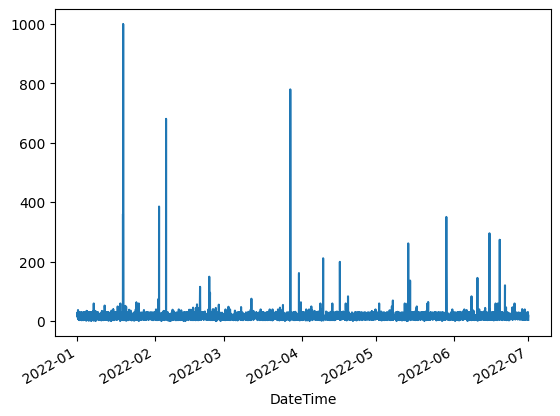

In [43]:
import matplotlib.pyplot as plt
merged_df['MinDelay'].plot()
plt.show()

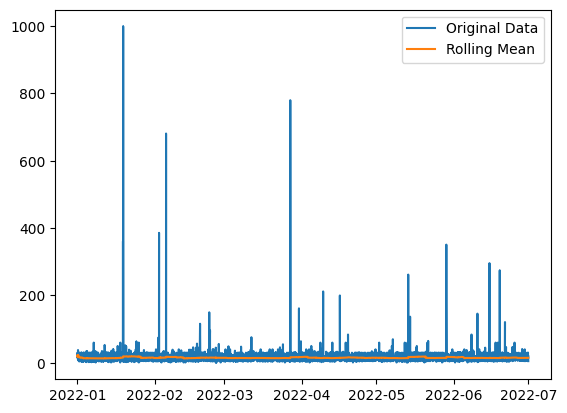

In [44]:
# Calculating the rolling mean of the 'MinDelay' column with a window of 7 days
merged_df = merged_df.sort_index()
rolling_mean = merged_df['MinDelay'].rolling(window='7D').mean()
plt.plot(merged_df['MinDelay'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean')
plt.legend()
plt.show()


In [45]:
merged_df.head()

,Location,Count,Route_x,latitude,longitude,Route_y,Day,Incident,MinDelay,MinGap,Direction,Vehicle,Month,Category
DateTime,,,,,,,,,,,,,,
2022-01-01 00:30:00,"DON MILLS STATION, Toronto",214,85,43.775725,-79.345277,85,Saturday,Operations - Operator,22,42,E,9076,January,1
2022-01-01 01:00:00,"COXWELL STATION, Toronto",88,70,43.684153,-79.323160,70,Saturday,Utilized Off Route,15,30,W,8435,January,2
2022-01-01 01:30:00,"WARDEN STATION, Toronto",284,17,43.710995,-79.279886,17,Saturday,Operations - Operator,18,36,N,3150,January,2
2022-01-01 01:30:00,"MAIN STATION, Toronto",67,20,43.819923,-79.181463,20,Saturday,Operations - Operator,15,15,N,8488,January,1
2022-01-01 02:00:00,"BINGHAM LOOP, Toronto",28,102,43.681505,-79.284808,102,Saturday,Operations - Operator,30,60,N,3419,January,2


## Holts Winter Exponential Smoothing

In [46]:

df_date_occurences = df.groupby('Date').size()
df_date_occurences

Date
2022-01-01    139
2022-01-02    130
2022-01-03    272
2022-01-04    221
2022-01-05    292
2022-01-06    264
2022-01-07    295
2022-01-08    171
2022-01-09     97
2022-01-10    231
2022-01-11    223
2022-01-12    183
2022-01-13    154
2022-01-14    192
2022-01-15    170
2022-01-16     95
2022-01-17    118
2022-01-18    201
2022-01-19    273
2022-01-20    232
2022-01-21    176
2022-01-22    110
2022-01-23    124
2022-01-24    180
2022-01-25    157
2022-01-26    165
2022-01-27    141
2022-01-28    153
2022-01-29    130
2022-01-30     74
2022-01-31    148
2022-02-01    124
2022-02-02    189
2022-02-03    187
2022-02-04    157
2022-02-05    100
2022-02-06     83
2022-02-07    127
2022-02-08    120
2022-02-09    141
2022-02-10    112
2022-02-11    130
2022-02-12    133
2022-02-13    125
2022-02-14    115
2022-02-15    110
2022-02-16    130
2022-02-17    221
2022-02-18    218
2022-02-19    151
2022-02-20    111
2022-02-21     66
2022-02-22    138
2022-02-23    126
2022-02-24    136
2022-

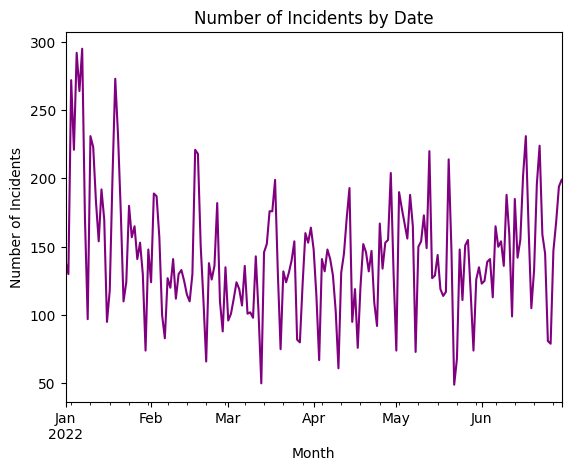

In [47]:
df_date_occurences.plot(kind='line', color='purple')
plt.title('Number of Incidents by Date')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')

plt.show()

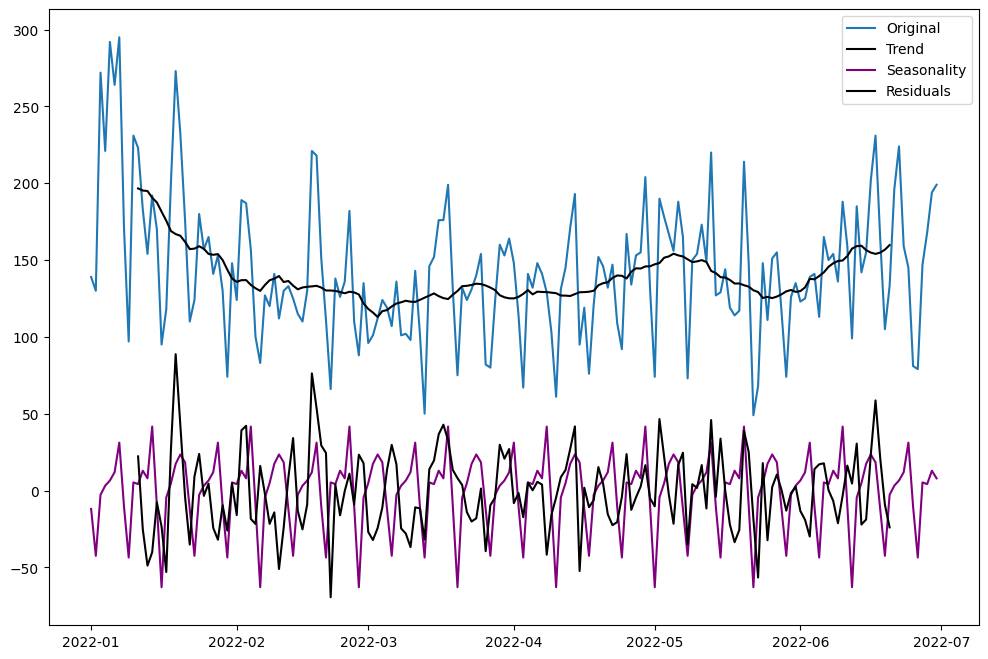

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# assuming 'df' is a pandas DataFrame with a datetime index
decomposition = seasonal_decompose(df_date_occurences, model='additive', period=21)

# retrieve the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# set the colors for the components
colors = ['black', 'purple', 'black', 'black']

# plot the decomposition with custom colors
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_date_occurences.index, df_date_occurences.values, label='Original')
ax.plot(trend.index, trend.values, label='Trend', color=colors[0])
ax.plot(seasonal.index, seasonal.values, label='Seasonality', color=colors[1])
ax.plot(residual.index, residual.values, label='Residuals', color=colors[2])
ax.legend(loc='best')
plt.show()


In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Using a Holt-Winters model to the time series with multiplicative seasonality (As it is hard to predict the magnitude of seasonality )
model = ExponentialSmoothing(df_date_occurences, seasonal='mul').fit()

# Forecasting the next 4 weeks (i.e., 30 data points) using the fitted model
forecast = model.forecast(30)

print(forecast)


2022-07-01    189.383161
2022-07-02    136.584787
2022-07-03     98.824263
2022-07-04    158.815321
2022-07-05    162.015883
2022-07-06    177.256930
2022-07-07    174.109542
2022-07-08    189.383161
2022-07-09    136.584787
2022-07-10     98.824263
2022-07-11    158.815321
2022-07-12    162.015883
2022-07-13    177.256930
2022-07-14    174.109542
2022-07-15    189.383161
2022-07-16    136.584787
2022-07-17     98.824263
2022-07-18    158.815321
2022-07-19    162.015883
2022-07-20    177.256930
2022-07-21    174.109542
2022-07-22    189.383161
2022-07-23    136.584787
2022-07-24     98.824263
2022-07-25    158.815321
2022-07-26    162.015883
2022-07-27    177.256930
2022-07-28    174.109542
2022-07-29    189.383161
2022-07-30    136.584787
Freq: D, dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



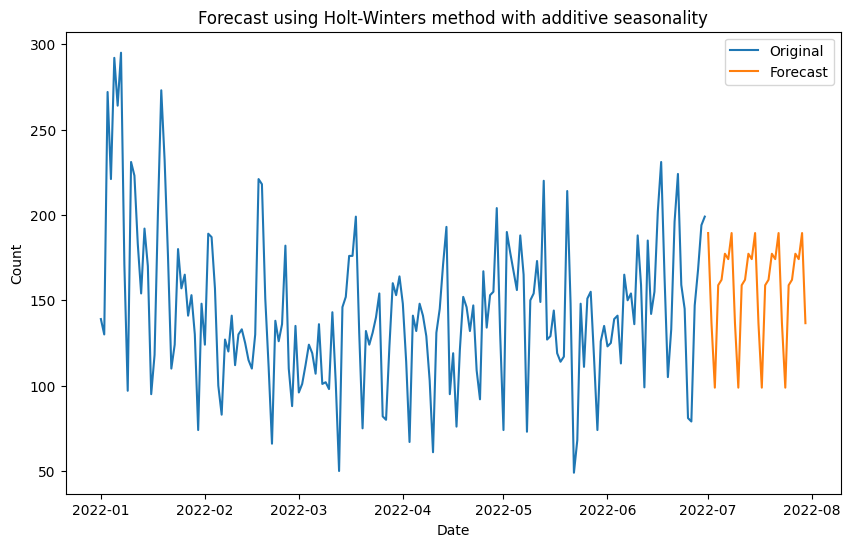

In [50]:
#@title
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_date_occurences.index, df_date_occurences.values, label='Original')
ax.plot(forecast.index, forecast.values, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Forecast using Holt-Winters method with additive seasonality')
ax.legend()
plt.show()


## Data Vizualizations:

In [51]:
# !pip install plotly

In [52]:
import plotly.graph_objs as go
from plotly.offline import iplot

<Axes: title={'center': "Delay's Incident"}, xlabel='Incident', ylabel='Delay in Hours'>

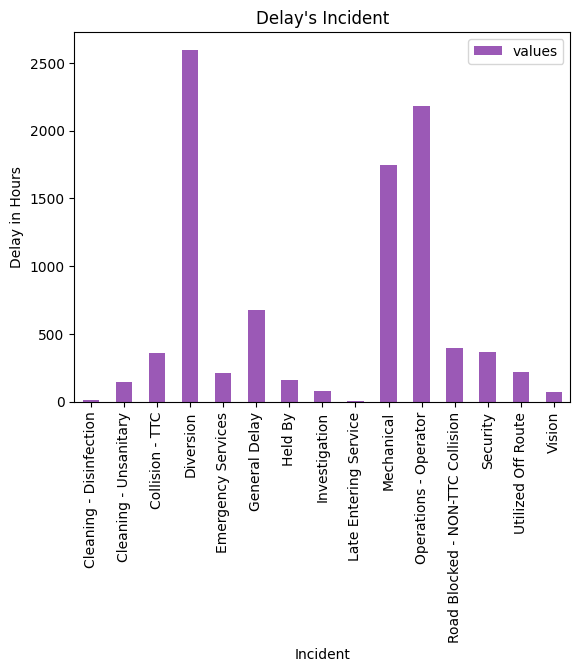

In [53]:
Incident = df.groupby(df['Incident'])['MinDelay'].sum()/60
df_no_incidents = pd.DataFrame({'labels': Incident.index,'values': Incident.values})
df_no_incidents.plot(kind='bar', x='labels', y='values', title="Delay's Incident", color='#9b59b6', xlabel='Incident', ylabel='Delay in Hours')

In [54]:
top_20_locations.head()

,Location,Count,Route,latitude,longitude
0,"KIPLING STATION, Toronto",608,300,43.637532,-79.535604
1,"PIONEER VILLAGE STATION, Toronto",576,41,43.776878,-79.508938
2,"KENNEDY STATION, Toronto",562,116,43.732619,-79.263717
3,"FINCH STATION, Toronto",553,53,43.782750,-79.414888
4,"EGLINTON STATION, Toronto",479,32,43.705354,-79.398821


In [55]:
top_locations = top_20_locations.groupby('Location').sum().sort_values(by='Count', ascending=False)[:10]

fig = px.scatter_mapbox(top_20_locations, lat='latitude', lon='longitude', hover_name='Location', hover_data=['Route'],
                        color='Route', size='Count', zoom=10, height=500,
                        mapbox_style='open-street-map')
fig.update_layout(title='Location vs. Route', mapbox_center_lon=top_locations['longitude'].mean(),
                  mapbox_center_lat=top_locations['latitude'].mean())
fig.show()

Text(0, 0.5, 'Delay in hours')

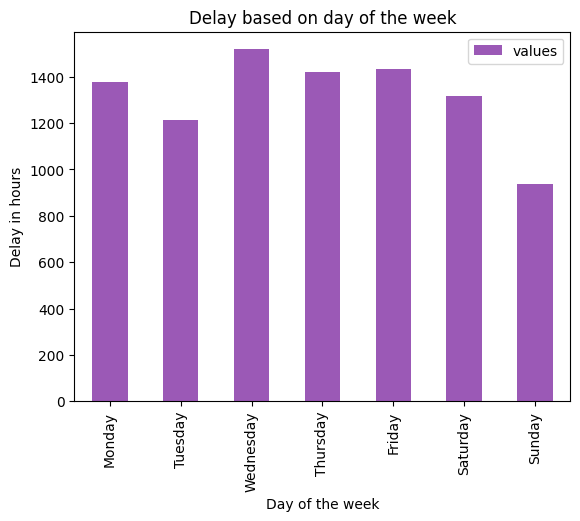

In [56]:
Day = df.groupby(df['Day'])['MinDelay'].sum() / 60
df_Day = pd.DataFrame({'labels': Day.index, 'values': Day.values})
order = pd.Categorical(df_Day['labels'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df_Day = df_Day.assign(labels=order).sort_values('labels')
ax = df_Day.plot(kind='bar', x='labels', y='values', title="Delay based on day of the week", color='#9b59b6')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Delay in hours')



<Axes: title={'center': "Average hours of Delay's noted due to the Incident"}, xlabel='Incident', ylabel='Delay in Hours'>

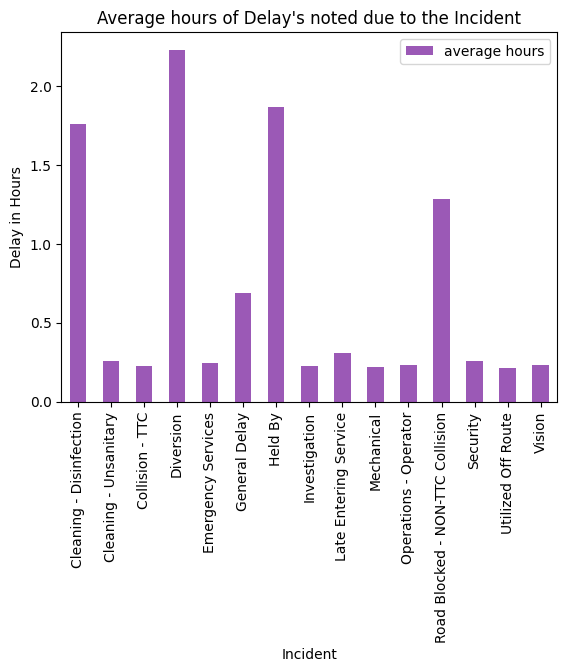

In [57]:
Incident = df.groupby(df['Incident'])['MinDelay'].mean() / 60
df_no_incidents = pd.DataFrame({'labels': Incident.index, 'average hours': Incident.values})
df_no_incidents.plot(kind='bar', x='labels', y='average hours', title="Average hours of Delay's noted due to the Incident", color='#9b59b6', xlabel='Incident', ylabel='Delay in Hours')

Text(0, 0.5, 'Total delay in Hours reported so far')

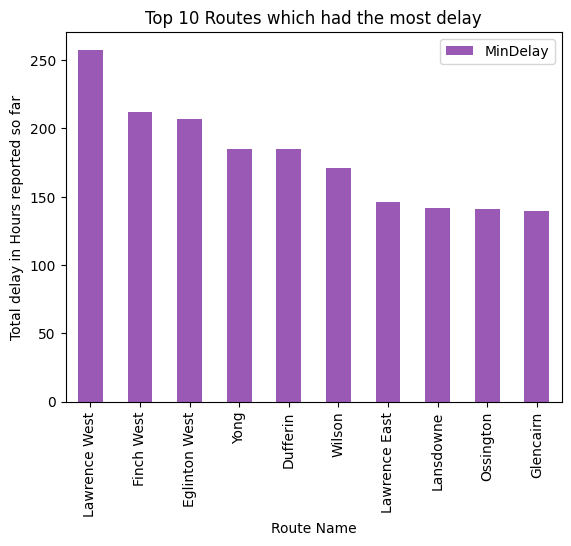

In [58]:
Route = df.groupby(df['Route'])['MinDelay'].sum().reset_index()
Route_20 = Route.sort_values(by=['MinDelay'], ascending=False).head(10)
Route_20['Route'] = Route_20['Route'].astype(str).replace({ '52':'Lawrence West', '36':'Finch West', '32':'Eglinton West', '97':'Yong',
                                      '29':'Dufferin', '96':'Wilson', '54':'Lawrence East', '47':'Lansdowne',
                                      '63':'Ossington', '14':'Glencairn'})
Route_20['MinDelay'] = Route_20['MinDelay']/60  # Convert delay time to hours
ax = Route_20.plot(kind='bar', x='Route', y='MinDelay', title="Top 10 Routes which had the most delay", color='#9b59b6')
ax.set_xlabel('Route Name')
ax.set_ylabel('Total delay in Hours reported so far')

Text(0, 0.5, 'Delay in Hours')

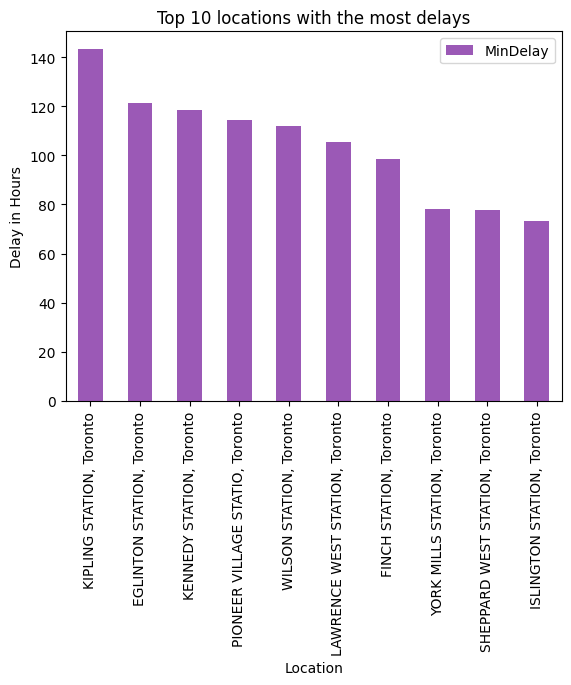

In [59]:
Location = df.groupby(df['Location'])['MinDelay'].sum().reset_index()
Location_20 = Location.sort_values(by = ['MinDelay'], ascending = False).head(10)
Location_20['MinDelay'] = Location_20['MinDelay'] / 60.0  # converting minutes to hours
ax = Location_20.plot(kind='bar', x='Location', y='MinDelay', title="Top 10 locations with the most delays", color='#9b59b6')
ax.set_xlabel('Location')
ax.set_ylabel('Delay in Hours')


In [60]:
top_locations = Location_20['Location'].tolist()
top_location_delays = df[df['Location'].isin(top_locations)].groupby(['Location', 'Incident'])['MinDelay'].sum().reset_index()
top_location_delays['MinDelay'] = top_location_delays['MinDelay'] / 60.0  # converting minutes to hours
top_location_delays = top_location_delays.sort_values(by=['Location', 'MinDelay'], ascending=False)
for location in top_locations:
    print(f"Top 3 causes of delay at {location}:")
    location_data = top_location_delays[top_location_delays['Location'] == location].head(3)
    for i, row in location_data.iterrows():
        print(f"{row['Incident']}: {row['MinDelay']} hours")
    print()


Top 3 causes of delay at KIPLING STATION, Toronto:
Operations - Operator: 69.23333333333333 hours
Mechanical: 51.416666666666664 hours
Security: 6.5 hours

Top 3 causes of delay at EGLINTON STATION, Toronto:
Operations - Operator: 58.13333333333333 hours
Mechanical: 31.55 hours
Utilized Off Route: 10.616666666666667 hours

Top 3 causes of delay at KENNEDY STATION, Toronto:
Operations - Operator: 43.516666666666666 hours
Mechanical: 35.0 hours
Utilized Off Route: 10.883333333333333 hours

Top 3 causes of delay at PIONEER VILLAGE STATIO, Toronto:
Operations - Operator: 51.86666666666667 hours
Mechanical: 39.6 hours
Utilized Off Route: 4.7 hours

Top 3 causes of delay at WILSON STATION, Toronto:
Operations - Operator: 53.86666666666667 hours
Mechanical: 37.583333333333336 hours
General Delay: 5.833333333333333 hours

Top 3 causes of delay at LAWRENCE WEST STATION, Toronto:
Operations - Operator: 44.61666666666667 hours
Mechanical: 24.2 hours
General Delay: 14.366666666666667 hours

Top 3 

In [61]:
from tabulate import tabulate

data = [
    ["KIPLING STATION", "Operations - Operator", 69.233],
    ["KIPLING STATION", "Mechanical", 51.416],
    ["KIPLING STATION", "Security", 6.5],
    ["EGLINTON STATION", "Operations - Operator", 58.133],
    ["EGLINTON STATION", "Mechanical", 31.55],
    ["EGLINTON STATION", "Utilized Off Route", 10.616],
    ["KENNEDY STATION", "Operations - Operator", 43.516],
    ["KENNEDY STATION", "Mechanical", 35.0],
    ["KENNEDY STATION", "Utilized Off Route", 10.883],
    ["PIONEER VILLAGE STATIO", "Operations - Operator", 51.866],
    ["PIONEER VILLAGE STATIO", "Mechanical", 39.6],
    ["PIONEER VILLAGE STATIO", "Utilized Off Route", 4.7],
    ["WILSON STATION", "Operations - Operator", 53.866],
    ["WILSON STATION", "Mechanical", 37.583],
    ["WILSON STATION", "General Delay", 5.833],
    ["LAWRENCE WEST STATION", "Operations - Operator", 44.616],
    ["LAWRENCE WEST STATION", "Mechanical", 24.2],
    ["LAWRENCE WEST STATION", "General Delay", 14.366],
    ["FINCH STATION", "Operations - Operator", 41.116],
    ["FINCH STATION", "Mechanical", 30.2],
    ["FINCH STATION", "Utilized Off Route", 5.466],
    ["YORK MILLS STATION", "Operations - Operator", 38.666],
    ["YORK MILLS STATION", "Mechanical", 20.716],
    ["YORK MILLS STATION", "General Delay", 4.166],
    ["SHEPPARD WEST STATION", "Mechanical", 33.183],
    ["SHEPPARD WEST STATION", "Operations - Operator", 31.566],
    ["SHEPPARD WEST STATION", "Utilized Off Route", 3.033],
    ["ISLINGTON STATION", "Operations - Operator", 47.166],
    ["ISLINGTON STATION", "Mechanical", 18.2],
    ["ISLINGTON STATION", "Security", 2.05],
]

headers = ["Location", "Cause of Delay", "Delay in Hours"]

print(tabulate(data, headers=headers))




Location                Cause of Delay           Delay in Hours
----------------------  ---------------------  ----------------
KIPLING STATION         Operations - Operator            69.233
KIPLING STATION         Mechanical                       51.416
KIPLING STATION         Security                          6.5
EGLINTON STATION        Operations - Operator            58.133
EGLINTON STATION        Mechanical                       31.55
EGLINTON STATION        Utilized Off Route               10.616
KENNEDY STATION         Operations - Operator            43.516
KENNEDY STATION         Mechanical                       35
KENNEDY STATION         Utilized Off Route               10.883
PIONEER VILLAGE STATIO  Operations - Operator            51.866
PIONEER VILLAGE STATIO  Mechanical                       39.6
PIONEER VILLAGE STATIO  Utilized Off Route                4.7
WILSON STATION          Operations - Operator            53.866
WILSON STATION          Mechanical                 

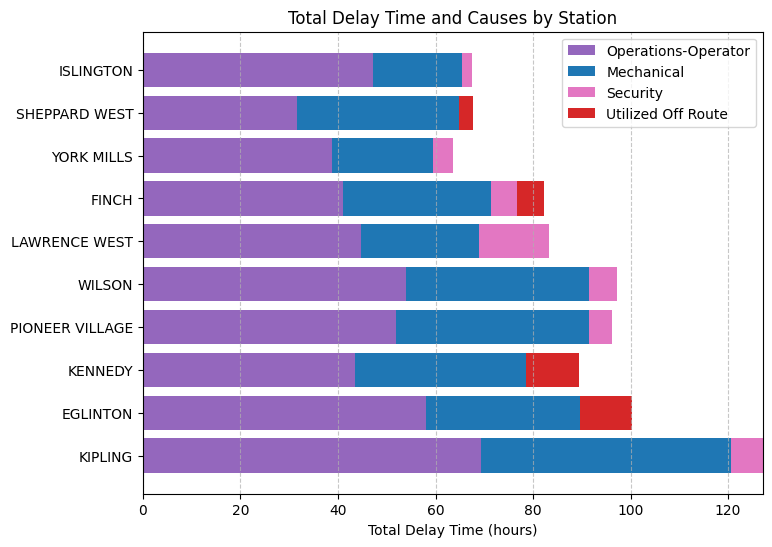

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Data
locations = ['KIPLING', 'EGLINTON', 'KENNEDY', 'PIONEER VILLAGE', 'WILSON', 'LAWRENCE WEST', 'FINCH', 'YORK MILLS', 'SHEPPARD WEST', 'ISLINGTON']
delays = [127.15, 100.29999999999998, 89.4, 96.06666666666668, 97.282, 83.18333333333332, 76.78333333333335, 63.548, 67.78333333333333, 67.41666666666667]
ops = [69.233, 58.133, 43.516, 51.866, 53.866, 44.616, 41.116, 38.666, 31.566, 47.166]
mech = [51.416, 31.55, 35, 39.6, 37.583, 24.2, 30.2, 20.716, 33.183, 18.2]
sec = [6.5, 0, 0, 4.7, 5.833, 14.366, 5.466, 4.166, 0, 2.05]
off_route = [0, 10.616, 10.883, 0, 0, 0, 5.466, 0, 3.033, 0]

# Create horizontal bars
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(locations, ops, color='tab:purple', label='Operations-Operator')
ax.barh(locations, mech, left=ops, color='tab:blue', label='Mechanical')
ax.barh(locations, sec, left=np.array(ops)+np.array(mech), color='tab:pink', label='Security')
ax.barh(locations, off_route, left=np.array(ops)+np.array(mech)+np.array(sec), color='tab:red', label='Utilized Off Route')

# Add x-axis label and legend
ax.set_xlabel('Total Delay Time (hours)')
ax.legend(loc='upper right')

# Add title and grid
ax.set_title('Total Delay Time and Causes by Station')
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


Text(0, 0.5, 'Delay count')

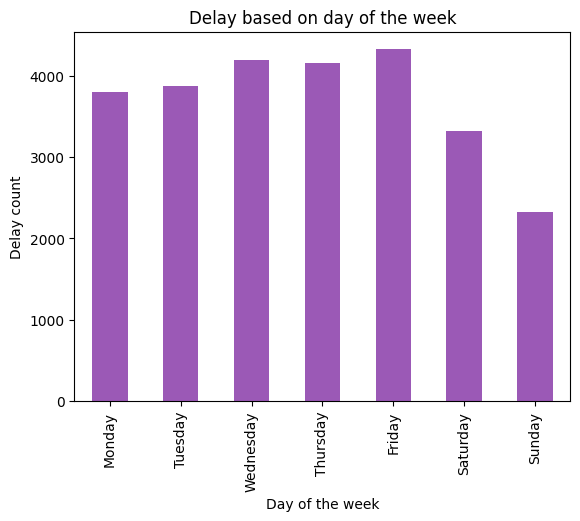

In [63]:
new_df = df.groupby(['Day']).size()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

new_df = new_df.reindex(day_order)
ax = new_df.plot(kind='bar', x='labels', y='values', title="Delay based on day of the week", color='#9b59b6')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Delay count')

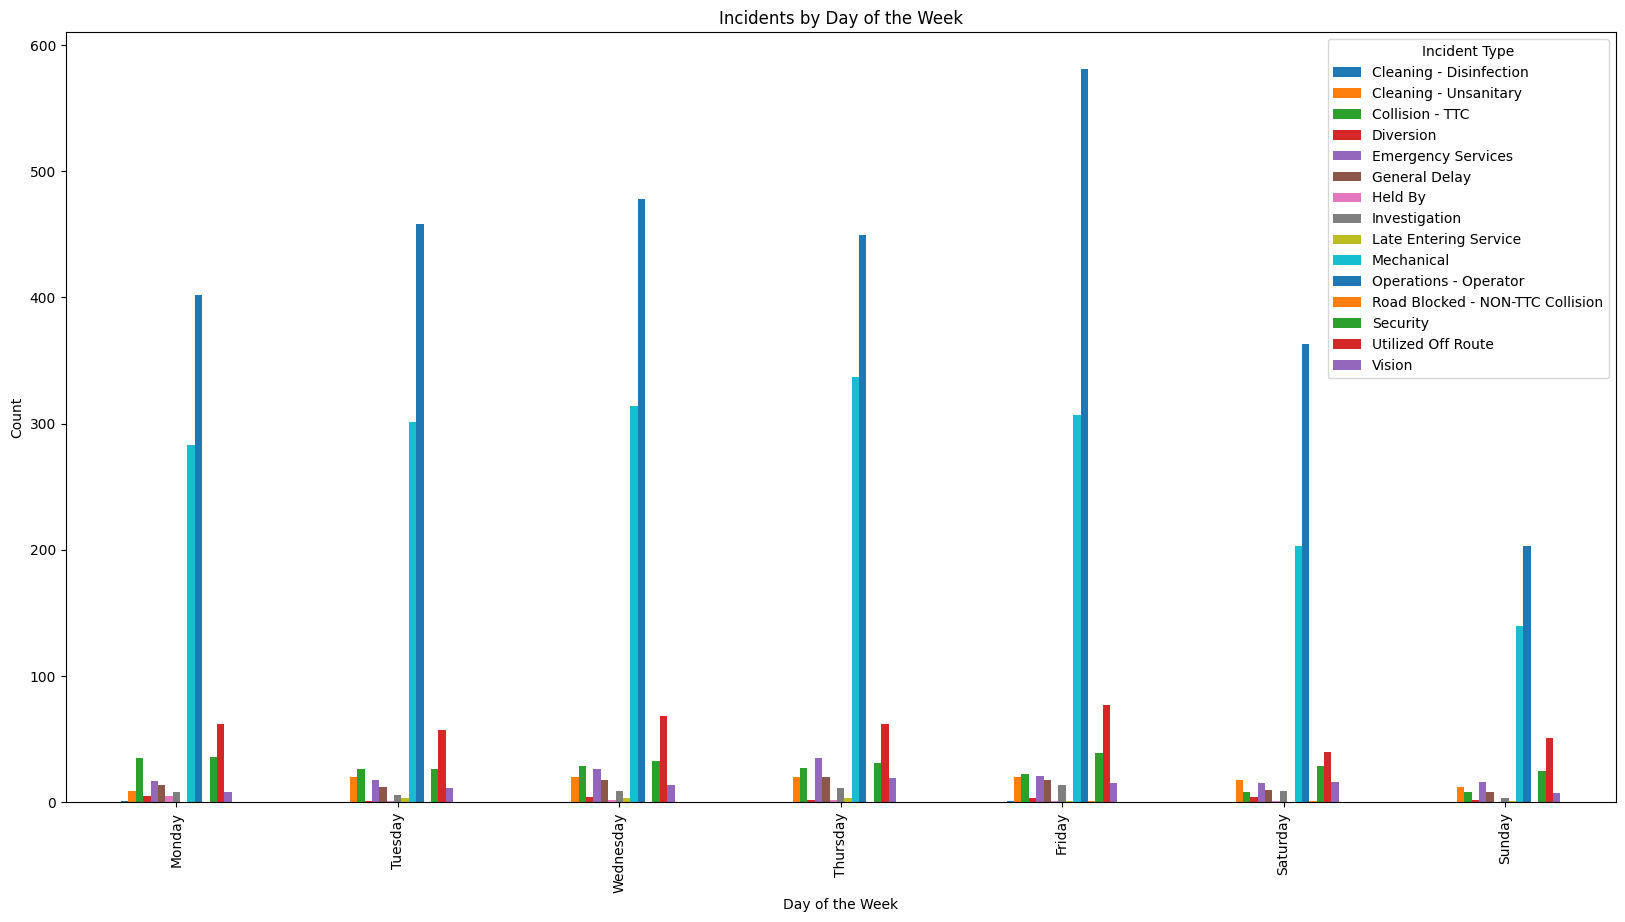

In [64]:
import matplotlib.pyplot as plt
merged_df_20 = pd.merge(top_20_locations, df, on='Location', how='inner')
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
incidents_by_day = merged_df_20.groupby(['Day', 'Incident'])['Count'].count().unstack().reindex(desired_order)

incidents_by_day.plot(kind='bar', figsize=(20, 10))
plt.title('Incidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Incident Type',loc='upper right')
plt.show()


In [65]:
months = range(1, 7) # January to June

for month in months:
    df_month = df.loc[df['Date'].dt.month == month]
    fig = px.scatter(df_month, x="Date", y="Incident", size="MinDelay")
    fig.update_layout(title_text=f"Incidents in Month {month}")
    fig.show()


In [66]:
fig = px.scatter(df, x="Date", y="Incident", color=df['Date'].dt.month, size="MinDelay")
fig.update_layout(title_text="Incidents from January to June")
fig.show()
